## Optimizing data for analysis with Amazon Athena and AWS Glue
by Manav Sehgal | on APR 30 2019


We will continue our open data analytics workflow starting with the AWS Console then moving to using the notebook. Using [AWS Glue](https://aws.amazon.com/glue/) we can automate creating a metadata catalog based on flat files stored on Amazon S3. Glue is a fully managed extract, transform, and load (ETL) service that makes it easy for customers to prepare and load their data for analytics. You can create and run an ETL job with a few clicks in the AWS Management Console. You simply point AWS Glue to your data stored on AWS, and AWS Glue discovers your data and stores the associated metadata (e.g. table definition and schema) in the AWS Glue Data Catalog. Once cataloged, your data is immediately searchable, queryable, and available for ETL.

### Glue Data Catalog

We have sourced the open dataset from the [Registry of Open Data on AWS](https://registry.opendata.aws/). We also stored the data on S3. Now we are ready to extract, transform, and load the data for analytics. We will use AWS Glue service to do this. First step is to create a logical database entry in the data catalog. Note that we are not creating a physical database which requires resources. This is just a metadata placeholder for the flat file we copied into S3.

> When creating the data catalog name try choosing a name without hyphens and few characters long. This will make SQL queries more readable and also avoid certain errors when running these queries.

![Glue Data Catalog](https://s3.amazonaws.com/cloudstory/notebooks-media/glue-data-catalog.png)

We can also setup the notebook for accessing AWS Glue service using the ``Boto3`` Python SDK. The ``pandas`` and ``IPython`` dependencies are imported for output formatting purposes only. We also import ``numpy`` a popular statistical analysis library. Charts and visualizations will be supported by ``seaborn`` and ``matplotlib`` libraries. To access the Glue service API we create a Glue client. 

In [180]:
import boto3
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [181]:
glue = boto3.client('glue')
s3 = boto3.client('s3')

### List Glue Databases
We will recreate the AWS Console GUI experience using SDK calls by creating the ``list_glue_databases`` function. We simply get the data catalogs in one statement and iterate over the results in the next one.

In [182]:
def list_glue_databases():
    glue_database = glue.get_databases()

    for db in glue_database['DatabaseList']:
        print(db['Name'])

In [183]:
list_glue_databases()

default
odoc
sampledb
taxicatalog


### Glue Crawler
Next, we create a logical table using Glue crawler. This is again just table metadata definition while the actual data is still stored only in the flat file on S3. For this notebook we will define and run the default Glue Crawler to extract and load the metadata schema from our flat file. This requires selection of a data store which is S3 in this case, defining an IAM role for access from Glue to S3, selecting a schedule for the crawler to run repeatedly if required, and output destination of the crawler results. 

> Please ensure that the flat file is stored on S3 within its own folder and you point at the folder when picking the data source during crawler definition. If you point directly to a flat file when running the crawler, it may return zero results when querying using Amazon Athena.

Glue will pick up folder name for the logical table name. Keeping our data source files in a folder has the added advantage of incremntally updating the folder with updates to the data with more files or updating the original file. Glue will pick up these changes based on crawler run schedule.

![Glue Crawler](https://s3.amazonaws.com/cloudstory/notebooks-media/glue-crawler.png)

### Glue Table Metadata
This results in extraction of table metadata stored within our data catalog. The schema with data types is extracted and stored in Glue Data Catalog. Note that the default Glue Crawler understands well-formed CSV files with first row as comma-separated list of column names, and next set of rows representing ordered data records. The Glue Crawler automatically guesses data types based on the contents of the flat file.

![Table Metadata](https://s3.amazonaws.com/cloudstory/notebooks-media/table-metadata.png)

### Transform Data Using Athena

Transforming big data in notebook environment is not viable. Instead we can use Amazon Athena for large data transforms and bring the results back into our notebook.

![Athena Transform Data](https://s3.amazonaws.com/cloudstory/notebooks-media/athena-transform-data.png)

We will use following query to create a well formed table transformed from our original table. Note that we specify the output location so that Athena defined WorkGroup location is not used by default. We also specify the format as ``TEXTFILE`` otherwise default ``PARQUET`` format is used which may generate errors when sampling this data.

```SQL
CREATE TABLE 
IF NOT EXISTS "taxicatalog"."many_trips_well_formed" 
WITH (
    external_location = 's3://open-data-analytics-taxi-trips/many-trips-well-formed/',
    format = 'TEXTFILE',
    field_delimiter = ','
)
AS SELECT vendorid AS vendor,
         passenger_count AS passengers,
         trip_distance AS distance,
         ratecodeid AS rate,
         pulocationid AS pick_location,
         dolocationid AS drop_location,
         payment_type AS payment_type,
         fare_amount AS fare,
         extra AS extra_fare,
         mta_tax AS tax,
         tip_amount AS tip,
         tolls_amount AS toll,
         improvement_surcharge AS surcharge,
         total_amount AS total_fare,
         tpep_pickup_datetime AS pick_when,
         tpep_dropoff_datetime AS drop_when
FROM "taxicatalog"."many_trips";
```


### List Glue Tables
In the spirit of CloudStory API we will recreate the AWS Console feature which lists the tables and displays the metadata within one single reusable function. We get the list of table metadata stored within our data catalog by passing the ``database`` parameter. Next we iterate over each table object and display the name, source data file, number of records (estimate), average record size, data size in MB, and the name of the crawler used to extract the table metadata. We also display the list of column names and data types extracted as schema from the flat file stored on S3.

In [184]:
def list_glue_tables(database, verbose=True):
    glue_tables = glue.get_tables(DatabaseName=database)
    
    for table in glue_tables['TableList']:
        display(Markdown('**Table: ' + table['Name'] + '**'))
        display(Markdown('Location: ' + table['StorageDescriptor']['Location']))
        created = table['CreatedBy'].split('/')
        display(Markdown('Created by: ' + created[-1]))
        if verbose and created[-1] == 'AWS Crawler':
            display(Markdown(f'Records: {int(table["Parameters"]["recordCount"]):,}'))
            display(Markdown(f'Average Record Size: {table["Parameters"]["averageRecordSize"]} Bytes'))
            display(Markdown(f'Dataset Size: {float(table["Parameters"]["sizeKey"])/1024/1024:3.0f} MB'))
            display(Markdown(f'Crawler: {table["Parameters"]["UPDATED_BY_CRAWLER"]}'))
        if verbose:
            df_columns = pd.DataFrame.from_dict(table["StorageDescriptor"]["Columns"])
            display(df_columns[['Name', 'Type']])
            display(Markdown('---'))

In [185]:
list_glue_tables('taxicatalog', verbose=False)

**Table: many_trips**

Location: s3://open-data-analytics-taxi-trips/many-trips/

Created by: AWS-Crawler

**Table: many_trips_well_formed**

Location: s3://open-data-analytics-taxi-trips/many-trips-well-formed

Created by: manav

In [186]:
athena = boto3.client('athena')

### Athena Query
Our next action is to bring the data created within Athena into the notebook environment using a ``pandas`` DataFrame. This can be done using the ``athena_query`` function which calls the Amazon Athena API to execute a query and store the output within a bucket and folder. This output is then read by a DataFrame which is returned by the function.

In [187]:
def athena_query(query, bucket, folder):
    output = 's3://' + bucket + '/' + folder + '/'
    response = athena.start_query_execution(QueryString=query, 
                                        ResultConfiguration={'OutputLocation': output})
    qid = response['QueryExecutionId']
    response = athena.get_query_execution(QueryExecutionId=qid)
    state = response['QueryExecution']['Status']['State']
    while state == 'RUNNING':
        response = athena.get_query_execution(QueryExecutionId=qid)
        state = response['QueryExecution']['Status']['State']
    key = folder + '/' + qid + '.csv'
    data_source = {'Bucket': bucket, 'Key': key}
    url = s3.generate_presigned_url(ClientMethod = 'get_object', Params = data_source)
    data = pd.read_csv(url)
    return data

To explore the data within Athena we will query returning thousand random samples.

In [188]:
bucket = 'open-data-analytics-taxi-trips'
folder = 'queries'
query = 'SELECT * FROM "taxicatalog"."many_trips_well_formed" TABLESAMPLE BERNOULLI(100) LIMIT 1000;'

df = athena_query(query, bucket, folder)
df.head()

,vendor,passengers,distance,rate,pick_location,drop_location,payment_type,fare,extra_fare,tax,tip,toll,surcharge,total_fare,pick_when,drop_when
0,2,1,1.66,1,186,79,1,11.5,0.0,0.5,3.69,0.0,0.3,15.99,2018-06-25 12:08:55,2018-06-25 12:24:55
1,1,1,0.50,1,151,151,2,4.0,0.0,0.5,0.00,0.0,0.3,4.80,2018-06-25 12:17:33,2018-06-25 12:20:18
2,1,1,0.70,1,239,143,1,5.0,0.0,0.5,1.15,0.0,0.3,6.95,2018-06-25 12:27:45,2018-06-25 12:32:21
3,1,1,1.10,1,143,48,1,8.5,0.0,0.5,1.85,0.0,0.3,11.15,2018-06-25 12:34:45,2018-06-25 12:45:39
4,1,1,3.00,1,48,144,1,18.0,0.0,0.5,3.75,0.0,0.3,22.55,2018-06-25 12:50:28,2018-06-25 13:17:50


Next we will determine statistical correlation between various features (columns) within the given set of samples (records).

In [189]:
corr = df.corr(method ='spearman')
corr

,vendor,passengers,distance,rate,pick_location,drop_location,payment_type,fare,extra_fare,tax,tip,toll,surcharge,total_fare
vendor,1.000000,0.238296,0.077524,0.068357,-0.092944,-0.034407,-0.036761,0.074508,-0.036058,-0.023648,0.030579,0.084248,NaN,0.081624
passengers,0.238296,1.000000,0.095732,-0.005490,-0.076036,-0.076054,0.014215,0.081750,-0.017374,-0.001874,-0.015566,0.069677,NaN,0.076785
distance,0.077524,0.095732,1.000000,0.242507,-0.141246,-0.096056,-0.062153,0.938340,0.052227,-0.054501,0.298860,0.436946,NaN,0.925564
rate,0.068357,-0.005490,0.242507,1.000000,-0.042799,0.041559,0.000932,0.299689,-0.005752,-0.354991,0.037742,0.425105,NaN,0.297754
pick_location,-0.092944,-0.076036,-0.141246,-0.042799,1.000000,0.059865,-0.048540,-0.133984,-0.030212,-0.007770,-0.009387,-0.128544,NaN,-0.123821
drop_location,-0.034407,-0.076054,-0.096056,0.041559,0.059865,1.000000,-0.039523,-0.088936,-0.046106,0.010432,-0.013009,-0.062082,NaN,-0.081411
payment_type,-0.036761,0.014215,-0.062153,0.000932,-0.048540,-0.039523,1.000000,-0.054463,-0.023117,-0.063883,-0.794920,-0.057032,NaN,-0.193921
fare,0.074508,0.081750,0.938340,0.299689,-0.133984,-0.088936,-0.054463,1.000000,0.053676,-0.100019,0.300108,0.436757,NaN,0.983445
extra_fare,-0.036058,-0.017374,0.052227,-0.005752,-0.030212,-0.046106,-0.023117,0.053676,1.000000,0.002005,0.055899,-0.009071,NaN,0.053543
tax,-0.023648,-0.001874,-0.054501,-0.354991,-0.007770,0.010432,-0.063883,-0.100019,0.002005,1.000000,0.068946,-0.173752,NaN,-0.098109


We can drop features which show ``NaN`` correlation.

In [190]:
df = df.drop(columns=['surcharge'])

In [191]:
corr = df.corr(method ='spearman')

Completing the data science workflow from sourcing big data, wrangling it using Amazon Athena to well formed schema, bringing adequate sample data from Athena to notebook environment, conducting exploratory data analysis, and finally visualizing the results.

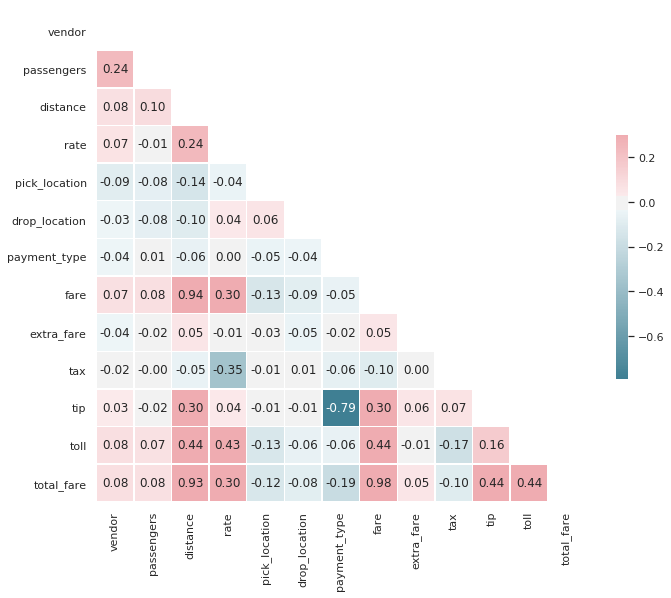

In [192]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt="3.2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Optimizing data for analysis with Amazon Athena and AWS Glue
by Manav Sehgal | on APR 30 2019
